In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import math
import os

plt.style.use('Solarize_Light2')

sales_train = pd.read_csv('./data/sales_train.csv')
items = pd.read_csv('./data/items.csv')
categories = pd.read_csv('./data/item_categories.csv')
shops = pd.read_csv('./data/shops.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [2]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
train = sales_train.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


# EDA

In [4]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


<AxesSubplot:title={'center':'Item Price (Training set)'}>

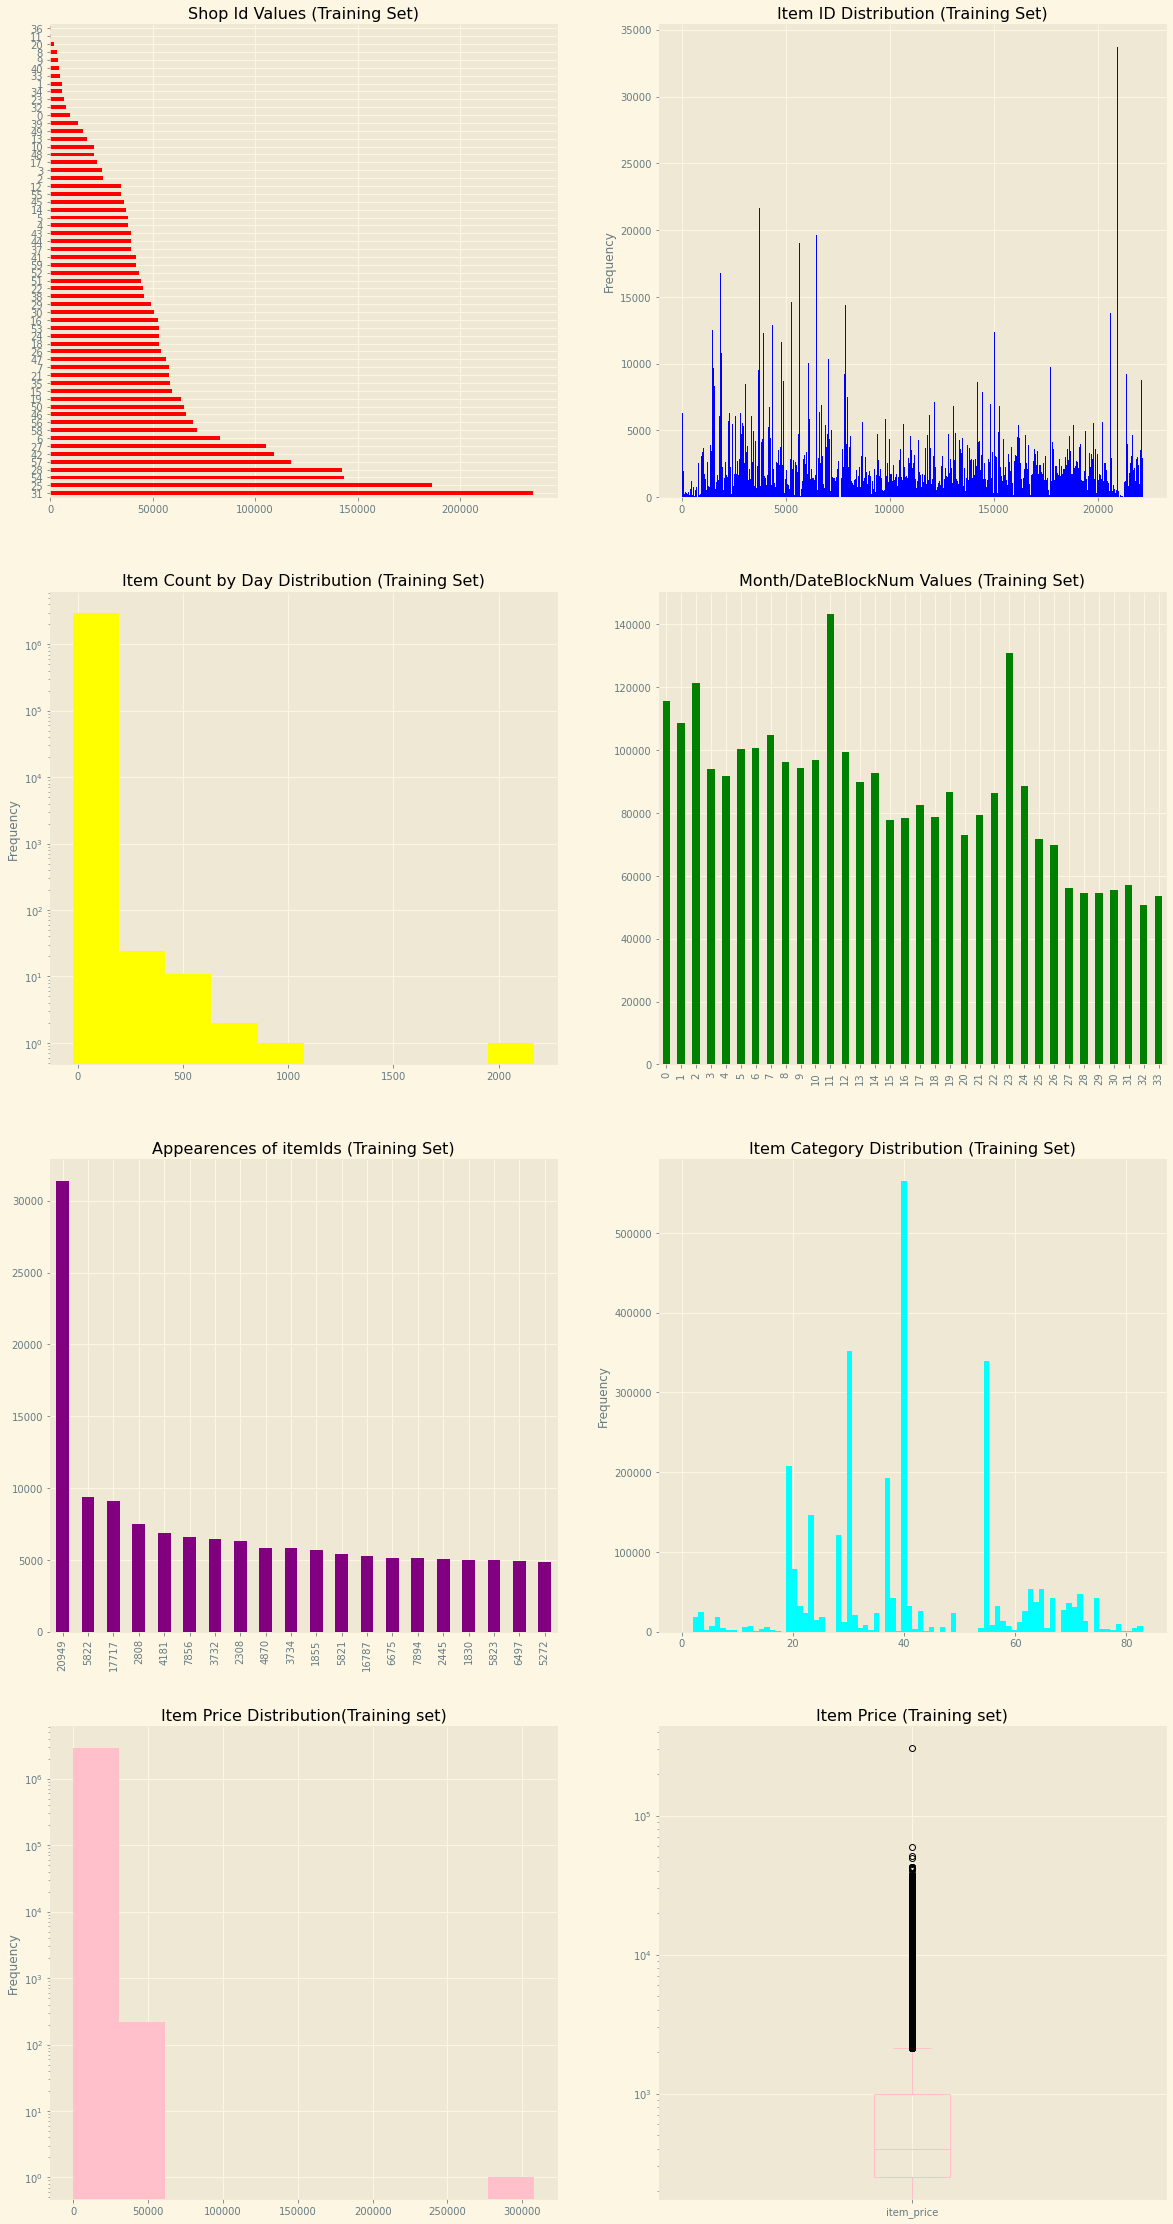

In [5]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,40))
train.shop_id.value_counts().plot.barh(color='red', ax=ax1, title='Shop Id Values (Training Set)')
train.item_id.plot.hist(bins=1000,color='blue', ax=ax2, title='Item ID Distribution (Training Set)')
train.item_cnt_day.plot.hist(color='yellow', logy=True, ax=ax3, title='Item Count by Day Distribution (Training Set)')
train.date_block_num.value_counts(sort=False).plot.bar(color='green', ax=ax4, title='Month/DateBlockNum Values (Training Set)')
train.item_id.value_counts()[:20].plot.bar(color='purple', ax=ax5, title='Appearences of itemIds (Training Set)')
train.item_category_id.plot.hist(bins=84, color='cyan', ax=ax6, title='Item Category Distribution (Training Set)')
train.item_price.plot.hist(logy=True, color='pink', ax=ax7, title='Item Price Distribution(Training set)')
train.item_price.plot.box(logy=True, color='pink', ax=ax8, title='Item Price (Training set)')

red graph
* ~7-8 shops make up more than a quarter of sales

blue graph
* some items are more popular than others
* might have to do with item category

yellow graph
* **outlier** at \~2000, (\~2000 items were sold on that day)

green graph
* spikes in Decembers (block 11n)
* appears to be decreasing over time

purple graph
* 20 most popular items
* **outlier** with itemid 20949

cyan graph
* the 7 most popular categories make up the majority
* **outlier** with category id 40

pink graphs
* **outlier** price ~300K

# Outliers

## Yellow graph item_cnt_day outlier

In [6]:
train.item_cnt_day.sort_values(ascending=False)

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
            ...  
59156        -6.0
940092       -6.0
2048519      -9.0
1835454     -16.0
1057907     -22.0
Name: item_cnt_day, Length: 2935849, dtype: float64

In [7]:
train.loc[train.item_cnt_day==2169].merge(items, on=['item_id', 'item_category_id'], how='left').merge(categories, on='item_category_id', how='left')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_name,item_category_name
0,28.10.2015,33,12,11373,0.908714,2169.0,9,Доставка до пункта выдачи (Boxberry),Доставка товара


Through google translate,  
"Доставка до пункта выдачи (Boxberry)" means "Delivery to the point of issue (Boxberry)", and  
"Доставка товара" means "Delivery of goods"  
Let's investigate item_id 11373 and item_category_id 9 in particular

In [8]:
train.loc[train.item_id==11373]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
58323,08.01.2013,0,12,11373,1000.00,1.0,9
58324,31.01.2013,0,12,11373,97.80,5.0,9
176790,01.02.2013,1,12,11373,229.00,1.0,9
176791,04.02.2013,1,12,11373,130.00,1.0,9
302468,29.03.2013,2,12,11373,139.50,2.0,9
...,...,...,...,...,...,...,...
2909829,07.10.2015,33,12,11373,855.00,2.0,9
2909830,06.10.2015,33,12,11373,208.80,5.0,9
2909831,05.10.2015,33,12,11373,140.75,16.0,9
2909832,02.10.2015,33,12,11373,648.50,2.0,9


<AxesSubplot:title={'center':'Sales (by day) Distribution of Item 11373 (Excluding Outlier)'}, ylabel='Frequency'>

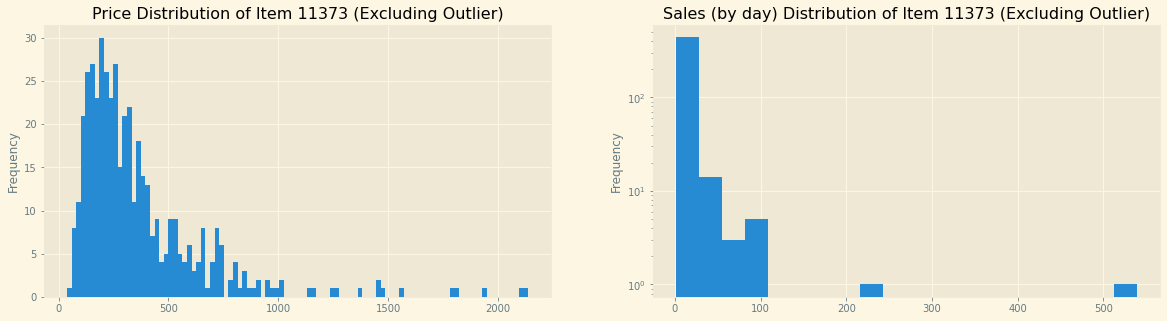

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
train.loc[(train.item_id==11373) & (train.item_cnt_day!=2169)].item_price.plot.hist(bins=100, ax=ax1, title='Price Distribution of Item 11373 (Excluding Outlier)')
train.loc[(train.item_id==11373) & (train.item_cnt_day!=2169)].item_cnt_day.plot.hist(bins=20, logy=True, ax=ax2, title='Sales (by day) Distribution of Item 11373 (Excluding Outlier)')

Looking at the graph on the right, a sale of 2169 is quite the anomaly when its daily sales are usually between 0-100  
Let's have a closer look at its price as well

In [10]:
train.loc[(train.item_id==11373) & (train.item_price<=100)].sort_values('item_price').head()
# train.loc[train.item_id==11373, ['item_cnt_day', 'item_price']].describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2909818,28.10.2015,33,12,11373,0.908714,2169.0,9
2257993,31.12.2014,23,12,11373,38.500000,4.0,9
2048642,30.10.2014,21,12,11373,71.000000,2.0,9
1058343,29.11.2013,10,12,11373,72.200000,105.0,9
2462729,26.02.2015,25,12,11373,75.454545,11.0,9


We can see that both the price (0.908) and sale (2169) of this item is an anomaly, so we should get rid of it

<AxesSubplot:title={'center':'New Item Count by Day Distribution (Without Outlier)'}, ylabel='Frequency'>

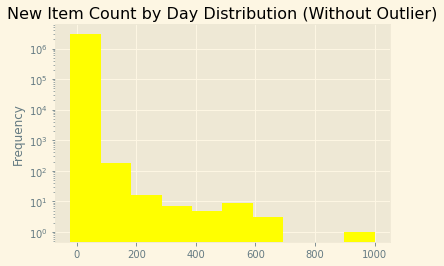

In [11]:
train = train.loc[train.item_cnt_day!=2169]
train.item_cnt_day.plot.hist(color='yellow', logy=True, title='New Item Count by Day Distribution (Without Outlier)')

Wait, 1000 might be an outlier too! Let's check if there are more...

## item_cnt_day 1000 outlier and item 20949 outlier

In [12]:
train.loc[train.item_cnt_day > 700]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2326930,15.01.2015,24,12,20949,4.0,1000.0,71


<AxesSubplot:title={'center':'Price Distribution of item 20949'}, ylabel='Frequency'>

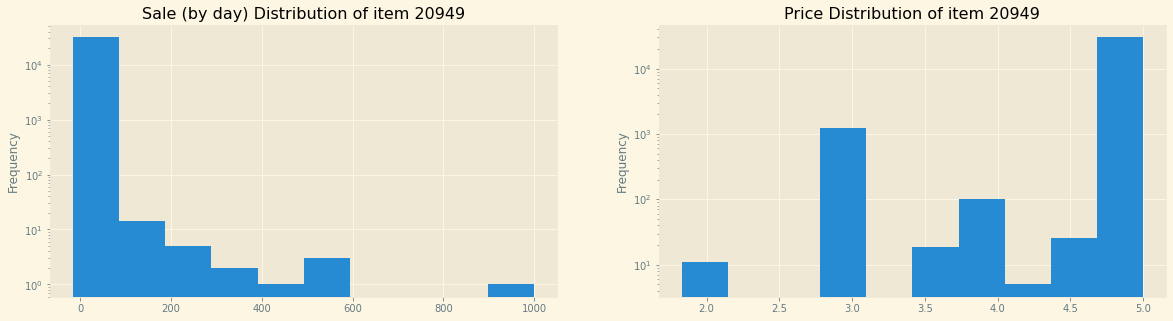

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
train.loc[train.item_id==20949].item_cnt_day.plot.hist(logy=True,ax=ax1, title='Sale (by day) Distribution of item 20949')
train.loc[train.item_id==20949].item_price.plot.hist(logy=True, ax=ax2, title='Price Distribution of item 20949')

In [14]:
train.loc[train.item_id==20949].describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,31340.000000,31340.000000,31340.0,31340.000000,31340.000000,31340.0
mean,17.683344,31.632833,20949.0,4.914856,5.987301,71.0
std,8.255712,16.907710,0.0,0.398042,11.497655,0.0
min,3.000000,2.000000,20949.0,1.830000,-16.000000,71.0
25%,11.000000,18.000000,20949.0,5.000000,2.000000,71.0
50%,17.000000,30.000000,20949.0,5.000000,3.000000,71.0
75%,24.000000,46.000000,20949.0,5.000000,7.000000,71.0
max,33.000000,59.000000,20949.0,5.000000,1000.000000,71.0


Its price is normal but we can see that 1000 sales on a day is also an anomaly since it is usually 2-7

But before we remove it, from the purple graph earlier, we actually saw that item 20949 is the most popular item (by a lot!). Let's find out what it is first!

In [15]:
items.loc[items.item_id==20949].merge(categories, on='item_category_id', how='left')

,item_name,item_id,item_category_id,item_category_name
0,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"


Google translate is a bit confusing this time, but with a bit of resesarch, the item is a plastic bag\!  
The outlier is on day 15/1/2015 in shop 12, perhaps it can be justified if there were lots of items sold in that shop on that day since there might be a correlation between items sales and plastic bag counts?

<AxesSubplot:title={'center':'Other Item Sales vs Plastic Bags Per Date and Shop'}, xlabel='item_cnt_day_x', ylabel='item_cnt_day_y'>

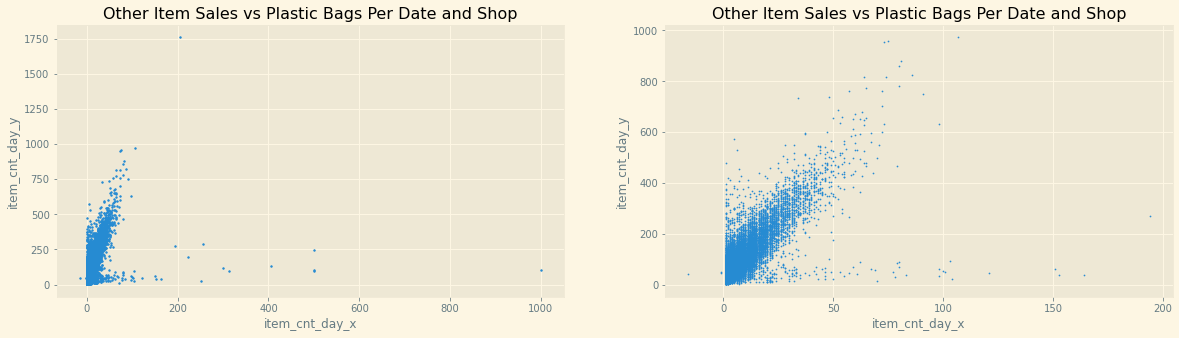

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
plastic_train = train.copy()
plastic_train['is_plastic_bag'] = plastic_train.item_id.apply(lambda x: x==20949)
counts = plastic_train.groupby(['date', 'is_plastic_bag', 'shop_id']).sum().item_cnt_day.reset_index()
plastic = counts.loc[counts.is_plastic_bag==True].merge(counts.loc[counts.is_plastic_bag==False], on=['date', 'shop_id'])
plastic.plot.scatter('item_cnt_day_x', 'item_cnt_day_y', ax=ax1, title='Other Item Sales vs Plastic Bags Per Date and Shop', s=2)
plastic.loc[plastic.item_cnt_day_x<=200].plot.scatter('item_cnt_day_x', 'item_cnt_day_y', ax=ax2, title='Other Item Sales vs Plastic Bags Per Date and Shop', s=0.5)

This confirms our intuition, there is a correlation\!  
But we can clearly see the outlier that we are investigating on the left graph.  
1000 plastic bags in a shop on a day with only 103 sales of other items is quite the anomaly. So let's get rid of it now.

In [17]:
train = train.loc[train.item_cnt_day<1000]
train.item_cnt_day.sort_values(ascending=False).head()

2864235    669.0
2851091    637.0
2608040    624.0
2626181    539.0
2851073    533.0
Name: item_cnt_day, dtype: float64

## cyan graph item category 40 outlier

In [18]:
# 4964 items in cat 40
#len(train.loc[train.item_category_id==40].item_id.unique())
# cat 40 ~ Кино - DVD cinema DVD
# categories.iloc[40]
# most popular movies
# items.merge(train.loc[train.item_category_id==40].groupby('item_id').sum().item_cnt_day.sort_values(ascending=False).head(), on='item_id', how='right')

## Pink $307980 price outlier investigation

In [19]:
train.loc[train.item_price==307980]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
1163158,13.12.2013,11,12,6066,307980.0,1.0,75


In [20]:
train.loc[train.item_id==6066].merge(items, on=['item_id', 'item_category_id']).merge(categories, on='item_category_id')
# Radmin 3 - 522 persons ; Programs - Home & Office

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_name,item_category_name
0,13.12.2013,11,12,6066,307980.0,1.0,75,Radmin 3 - 522 лиц.,Программы - Для дома и офиса


In [21]:
items[items.item_name.apply(lambda x: True if len(re.findall('radmin', x.lower()) if pd.notna(x) else x)!=0 else False)]

,item_name,item_id,item_category_id
6065,Radmin 3 - 1 лиц.,6065,75
6066,Radmin 3 - 522 лиц.,6066,75


In [22]:
train.loc[train.item_id==6065]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
291238,21.03.2013,2,22,6065,1299.0,1.0,75
291260,22.03.2013,2,22,6065,1299.0,1.0,75
318708,11.03.2013,2,25,6065,1299.0,1.0,75
370177,18.04.2013,3,12,6065,1299.0,1.0,75
375067,06.04.2013,3,6,6065,1299.0,1.0,75
379230,12.04.2013,3,22,6065,1299.0,1.0,75
379232,20.04.2013,3,22,6065,1299.0,2.0,75
487026,05.05.2013,4,54,6065,1299.0,1.0,75
542238,07.06.2013,5,29,6065,1299.0,1.0,75
679923,29.07.2013,6,22,6065,1299.0,1.0,75


A Radmin 3 install for a single person is usually 1299, but the outlier was an installation for 522 people at the discounted price of 590 per person.  
Purchases of a single install of Radmin 3 occurs quite often, a 522 person install for 307980 is not.  
We will get rid of it

In [23]:
train = train.loc[train.item_price < 300000]
train.sort_values('item_price', ascending=False).head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
885138,17.09.2013,8,12,11365,59200.0,1.0,9
1488135,20.03.2014,14,25,13199,50999.0,1.0,69
2327159,29.01.2015,24,12,7241,49782.0,1.0,75
2917760,20.10.2015,33,3,13403,42990.0,1.0,16
2910156,29.10.2015,33,12,13403,42990.0,1.0,16


# Other Anomalies

## Negative Prices

In [24]:
train.loc[train.item_price<=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
484683,15.05.2013,4,32,2973,-1.0,1.0,19


There's a single entry of a negative sale, looking at the plot below, all prices related to that item are between 1000 and 2500.  
So it's justifiable to remove it.

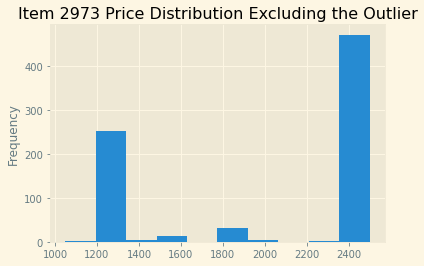

In [25]:
train.loc[(train.item_id==2973) & (train.item_price>0)].item_price.plot.hist(title='Item 2973 Price Distribution Excluding the Outlier')
train = train.loc[train.item_price>0]

## Negative Item Sales

7356 entries of negative sales in total


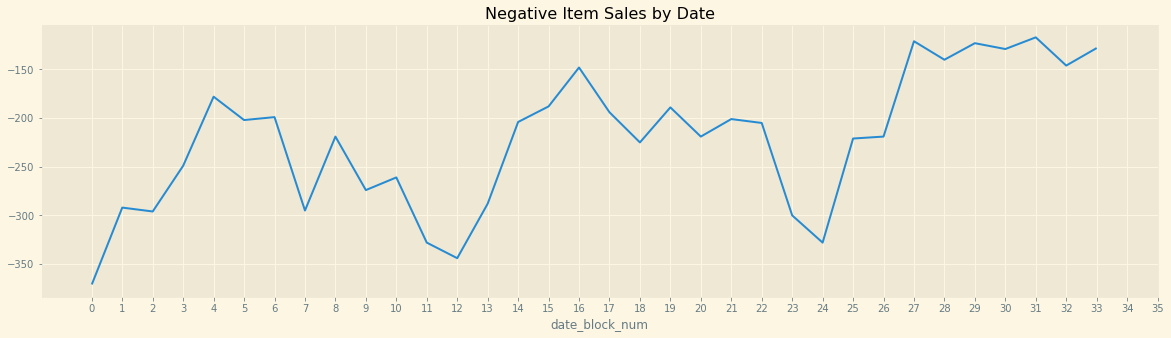

In [26]:
neg_sales = train.loc[train.item_cnt_day<=0]
neg_sales.groupby('date_block_num').sum().item_cnt_day.plot(figsize=(20,5), xticks=range(0,36), title='Negative Item Sales by Date')
print(neg_sales.shape[0], "entries of negative sales in total")

There seems to be an important pattern in negative sales in our data so we should definitely not discard all of them.  
We'll just look for some extreme outliers and cater them.

<AxesSubplot:title={'center':'Negative Item Sales Distribution'}, ylabel='Frequency'>

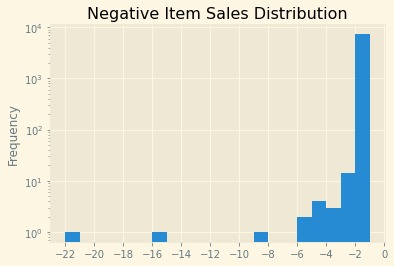

In [27]:
neg_sales.item_cnt_day.plot.hist(bins=range(-22,0), xticks=range(-22,1,2), logy=True, title='Negative Item Sales Distribution')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
59156,18.01.2013,0,12,1590,2599.000000,-6.0,29
940092,19.10.2013,9,42,3732,2599.000000,-6.0,19
1057907,02.11.2013,10,12,8023,15.000000,-22.0,66
2048519,10.10.2014,21,12,9242,1433.333333,-9.0,8
1835454,10.07.2014,18,14,20949,5.000000,-16.0,71


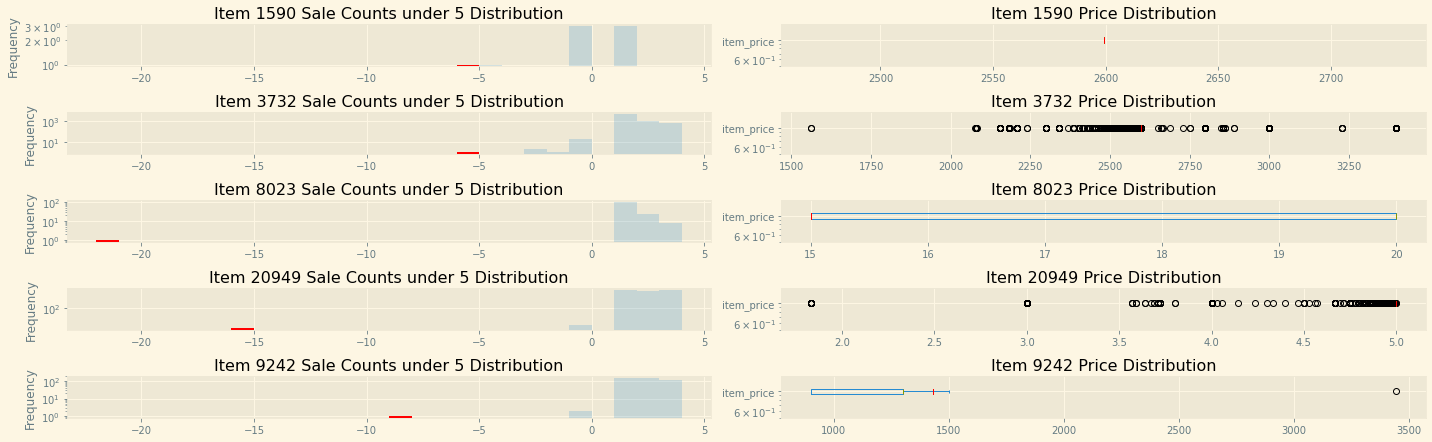

In [28]:
thresh = -6
nplots = len(train.loc[train.item_cnt_day<=thresh, 'item_id'].unique())

fig, axs = plt.subplots(nplots, 2, figsize=(20,nplots/0.8))
for i, itemid in enumerate(train.loc[train.item_cnt_day<=thresh, 'item_id'].unique()):
    train.loc[(train.item_id==itemid) & (train.item_cnt_day<=thresh)].item_cnt_day.plot.hist(bins=range(-22,5), color='red', logy=True, ax=axs[i][0])    
    train.loc[(train.item_id==itemid) & (train.item_cnt_day>thresh) & (train.item_cnt_day<5)].item_cnt_day.plot.hist(bins=range(-22,5), alpha = 0.2, logy=True, title='Item {} Sale Counts under 5 Distribution'.format(itemid), ax=axs[i][0])    
    
    train.loc[(train.item_id==itemid) & (train.item_cnt_day>thresh)].item_price.plot.box(vert=False, title='Item {} Price Distribution'.format(itemid), ax=axs[i][1])
    train.loc[(train.item_id==itemid) & (train.item_cnt_day<=thresh)].item_price.plot.box(vert=False, color='red', logy=True, ax=axs[i][1])
        
    
plt.tight_layout()
train.loc[train.item_cnt_day<=thresh].sort_values('item_id')

Let's take out all entries with item counts less than or equal to -6 except for item 3732.

<AxesSubplot:title={'center':'Negative Item Sales Distribution'}, ylabel='Frequency'>

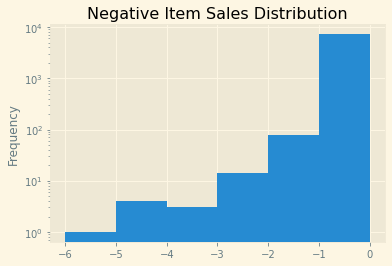

In [29]:
train = train.loc[(train.item_cnt_day>-6) | (train.item_id==3732)]
train.loc[train.item_cnt_day<=0].item_cnt_day.plot.hist(bins=range(-6,1), logy=True, title='Negative Item Sales Distribution')

# Similarities

In [30]:
from collections import Counter

def lev(s1, s2):
    s1n = len(s1)
    s2n = len(s2)
    d = np.zeros((s1n+1,s2n+1))
    for j in range(s2n+1):
        d[0,j] = j
    for i in range(s1n+1):
        d[i,0] = i
    for j in range(1, s2n+1):
        for i in range(1, s1n+1):            
            d[i,j] = min(d[i-1, j] + 1, d[i,j-1]+1, d[i-1,j-1]+(1 if s1[i-1]!=s2[j-1] else 0))            
    return d[-1,-1]

def cossim(s1, s2):
    v1 = Counter(s1)
    v2 = Counter(s2)    
    numerator = sum([v1[i] * v2[i] for i in (set(v1.keys()) & set(v2.keys()))])    
    sum1 = sum([v1[i] ** 2 for i in list(v1.keys())])
    sum2 = sum([v2[i] ** 2 for i in list(v2.keys())])    
    denom = (sum1**0.5) * (sum2**0.5)
    if not denom:
        return 0
    else:
        return float(numerator)/denom

def jw(s1, s2):
    s1n, s2n, m, t = len(s1), len(s2), 0, 0
    bound = math.floor( max(s1n, s2n) / 2 ) - 1    
    for c in s1:
        if c in s2:
            p1 = s1.index(c)
            p2 = s2.index(c)
            if abs(p1-p2) <= bound:
                m += 1
                if p1!=p2:
                    t += 1
    return 0 if m==0 else 1/3 * ( m/s1n + m/s2n + (m-t//2)/m)
    
def simmat(x, simfunc):
    d = np.empty((len(x),len(x)))
    for j, s2 in enumerate(x):
        for i, s1 in enumerate(x):
            d[i,j] = simfunc(s1,s2)
    return d

def vatorder(mat):
    dmax = mat.max()
    maxind = []
    order = []
    for i, x in enumerate(mat):
        for j, d in enumerate(x):
            if d == dmax and (j,i) not in maxind:
                maxind.append((i,j))    
    order.append(int(maxind[0][0]))    
    
    o = 0
    while o < len(mat)-1:        
        x = mat[order[o]]
        xtmp = x.copy()        
        for k in order:             
            xtmp[k] = np.nan        
        xmin = min(xtmp[~np.isnan(xtmp)])        
        for i, xx in enumerate(x):
            if xx==xmin and i not in order:
                order.append(i)                
                break
        o += 1
        
        
        
    return order

## Item Category Similarities

In [31]:
%%time
cat_levmat = simmat(categories.item_category_name, lev)
cat_cosmat = simmat(categories.item_category_name, cossim)
cat_invcosmat = 1 - cat_cosmat
cat_jwmat = simmat(categories.item_category_name, jw)
cat_invjwmat = 1 - cat_jwmat

CPU times: user 8.45 s, sys: 30.6 ms, total: 8.48 s
Wall time: 8.41 s


<AxesSubplot:title={'center':'Category Name Inverted Jaro-Winkler Similarities'}>

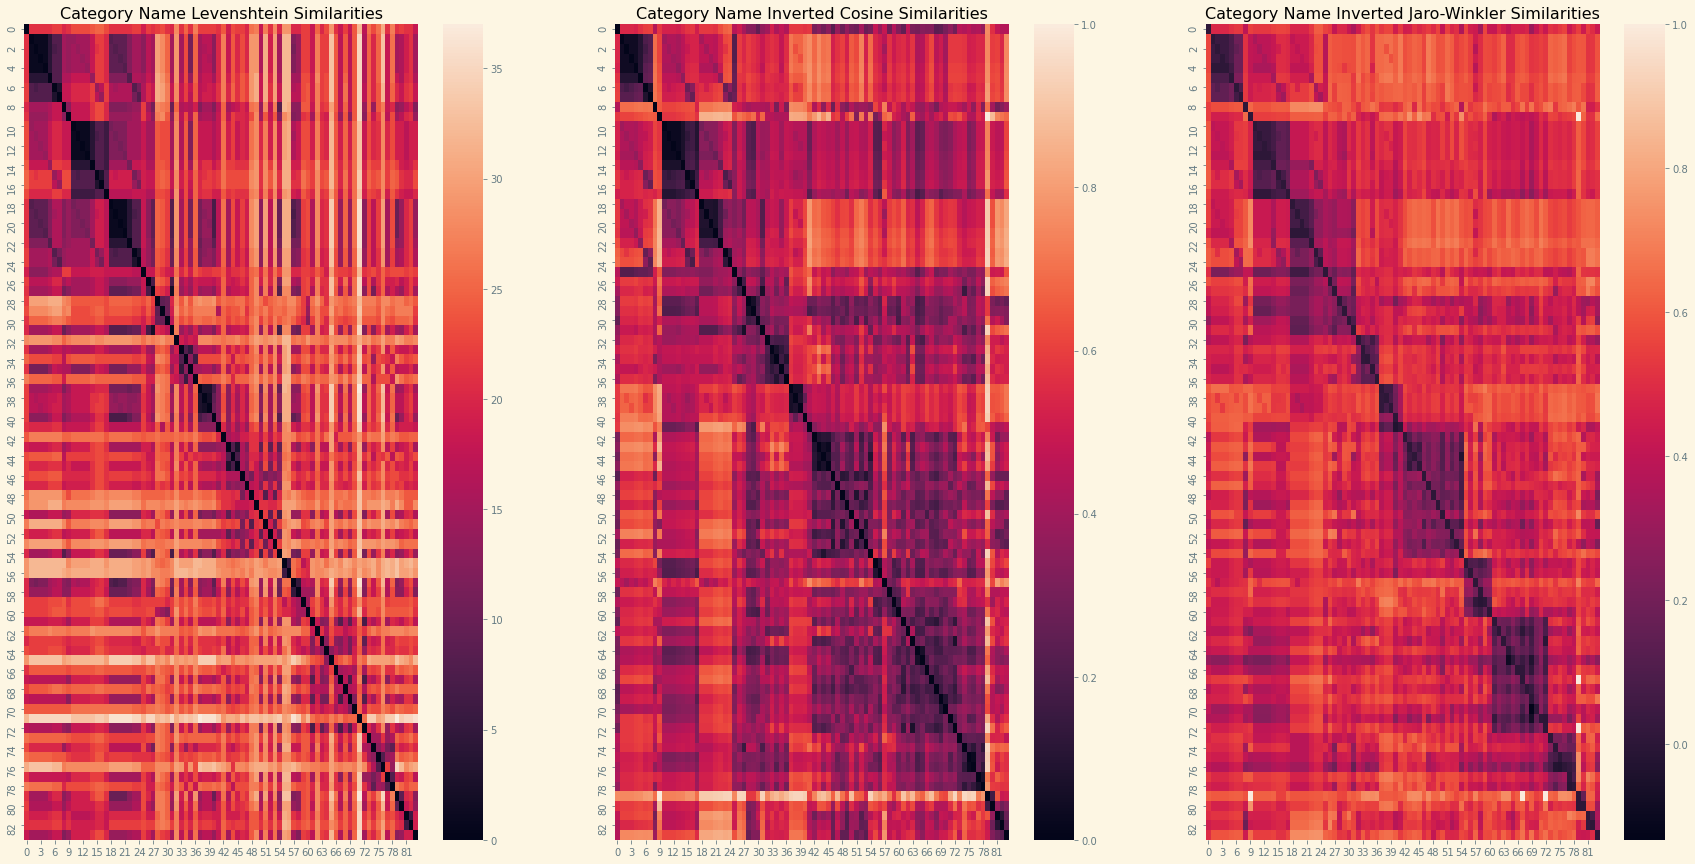

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 15))
ax1.set_title('Category Name Levenshtein Similarities')
ax2.set_title('Category Name Inverted Cosine Similarities')
ax3.set_title('Category Name Inverted Jaro-Winkler Similarities')
sns.heatmap(cat_levmat, ax=ax1)
sns.heatmap(cat_invcosmat, ax=ax2)
sns.heatmap(cat_invjwmat, ax=ax3)

In [33]:
categories.iloc[10:18]

,item_category_name,item_category_id
10,Игровые консоли - PS2,10
11,Игровые консоли - PS3,11
12,Игровые консоли - PS4,12
13,Игровые консоли - PSP,13
14,Игровые консоли - PSVita,14
15,Игровые консоли - XBOX 360,15
16,Игровые консоли - XBOX ONE,16
17,Игровые консоли - Прочие,17


As an example, all of the above categories fall under "Игровые консоли" which means "Game Console"

In [34]:
main_categories = categories.item_category_name.apply(lambda x: x.split('-')[0].strip())
print(len(main_categories.unique()), main_categories.unique())
categories.loc[categories.item_category_name.apply(lambda x: True if len(x.split('-'))==1 else False)]

20 ['PC' 'Аксессуары' 'Билеты (Цифра)' 'Доставка товара' 'Игровые консоли'
 'Игры' 'Игры Android' 'Игры MAC' 'Игры PC'
 'Карты оплаты (Кино, Музыка, Игры)' 'Карты оплаты' 'Кино' 'Книги'
 'Музыка' 'Подарки' 'Программы' 'Служебные' 'Чистые носители (шпиль)'
 'Чистые носители (штучные)' 'Элементы питания']


,item_category_name,item_category_id
8,Билеты (Цифра),8
9,Доставка товара,9
32,"Карты оплаты (Кино, Музыка, Игры)",32
79,Служебные,79
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82
83,Элементы питания,83


We realize that except for 7 categories, all of them have a main category before the hyphen in item_category_name, a total of 20 main categories.

It looks like 81 and 82 should be grouped together as well.  
There's a main category called "Карты оплаты" and 32 has the same prefix.  
Some of the main categories are also platform specific.

Let's add some labels with these in mind

In [35]:
categories.loc[81, 'item_category_name'] = 'Чистые носители - шпиль'
categories.loc[82, 'item_category_name'] = 'Чистые носители - штучные'
categories.loc[32, 'item_category_name'] = 'Карты оплаты - Кино, Музыка, Игры'
categories['sub_main_category_name'] = categories.item_category_name.apply(lambda x: x.split('-')[0].strip())
categories['sub_category_name'] = categories.item_category_name.apply(lambda x: x.split('-')[1].strip() if '-' in x else x)
categories['main_category_name'] = categories.sub_main_category_name.copy()
categories.main_category_name = categories.main_category_name.apply(lambda x: 'Игры' if 'Игры' in x else x)

In [36]:
categories[26:32]

,item_category_name,item_category_id,sub_main_category_name,sub_category_name,main_category_name
26,Игры Android - Цифра,26,Игры Android,Цифра,Игры
27,Игры MAC - Цифра,27,Игры MAC,Цифра,Игры
28,Игры PC - Дополнительные издания,28,Игры PC,Дополнительные издания,Игры
29,Игры PC - Коллекционные издания,29,Игры PC,Коллекционные издания,Игры
30,Игры PC - Стандартные издания,30,Игры PC,Стандартные издания,Игры
31,Игры PC - Цифра,31,Игры PC,Цифра,Игры


In [37]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categories['main_category_id'] = le.fit_transform(categories.main_category_name)
categories['sub_main_category_id'] = le.fit_transform(categories.sub_main_category_name)
categories['sub_category_id'] = le.fit_transform(categories.sub_category_name)

In [38]:
train = train.merge(categories[['item_category_id', 'main_category_id', 'sub_main_category_id', 'sub_category_id']], on='item_category_id', how='left')

In [39]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,main_category_id,sub_main_category_id,sub_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37,7,10,1
1,03.01.2013,0,25,2552,899.00,1.0,58,9,12,27
2,05.01.2013,0,25,2552,899.00,-1.0,58,9,12,27
3,06.01.2013,0,25,2554,1709.05,1.0,58,9,12,27
4,15.01.2013,0,25,2555,1099.00,1.0,56,9,12,3


In [40]:
categories

,item_category_name,item_category_id,sub_main_category_name,sub_category_name,main_category_name,main_category_id,sub_main_category_id,sub_category_id
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники,PC,0,0,29
1,Аксессуары - PS2,1,Аксессуары,PS2,Аксессуары,1,1,9
2,Аксессуары - PS3,2,Аксессуары,PS3,Аксессуары,1,1,10
3,Аксессуары - PS4,3,Аксессуары,PS4,Аксессуары,1,1,11
4,Аксессуары - PSP,4,Аксессуары,PSP,Аксессуары,1,1,13
...,...,...,...,...,...,...,...,...
79,Служебные,79,Служебные,Служебные,Служебные,12,15,54
80,Служебные - Билеты,80,Служебные,Билеты,Служебные,12,15,25
81,Чистые носители - шпиль,81,Чистые носители,шпиль,Чистые носители,13,16,63
82,Чистые носители - штучные,82,Чистые носители,штучные,Чистые носители,13,16,64


In [41]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 15))
# ax1.set_title('Category Name Levenshtein Similarities')
# ax2.set_title('Category Name Inverted Cosine Similarities')
# ax3.set_title('Category Name Inverted Jaro-Winkler Similarities')

# dendrogram(linkage(cat_levmat), ax=ax1)
# dendrogram(linkage(cat_invcosmat), ax=ax2)
# dendrogram(linkage(cat_invjwmat), ax=ax3)
# plt.show()

## Shop Similarities

In [42]:
%%time

shop_levmat = simmat(shops.shop_name[:5000], lev)
shop_cosmat = simmat(shops.shop_name, cossim)
shop_invcosmat = 1 - shop_cosmat
shop_jwmat = simmat(shops.shop_name, jw)
shop_invjwmat = 1 - shop_jwmat

CPU times: user 7.29 s, sys: 8.41 ms, total: 7.3 s
Wall time: 7.3 s


<AxesSubplot:title={'center':'Shop Name Inverted Jaro-Winkler Similarities'}>

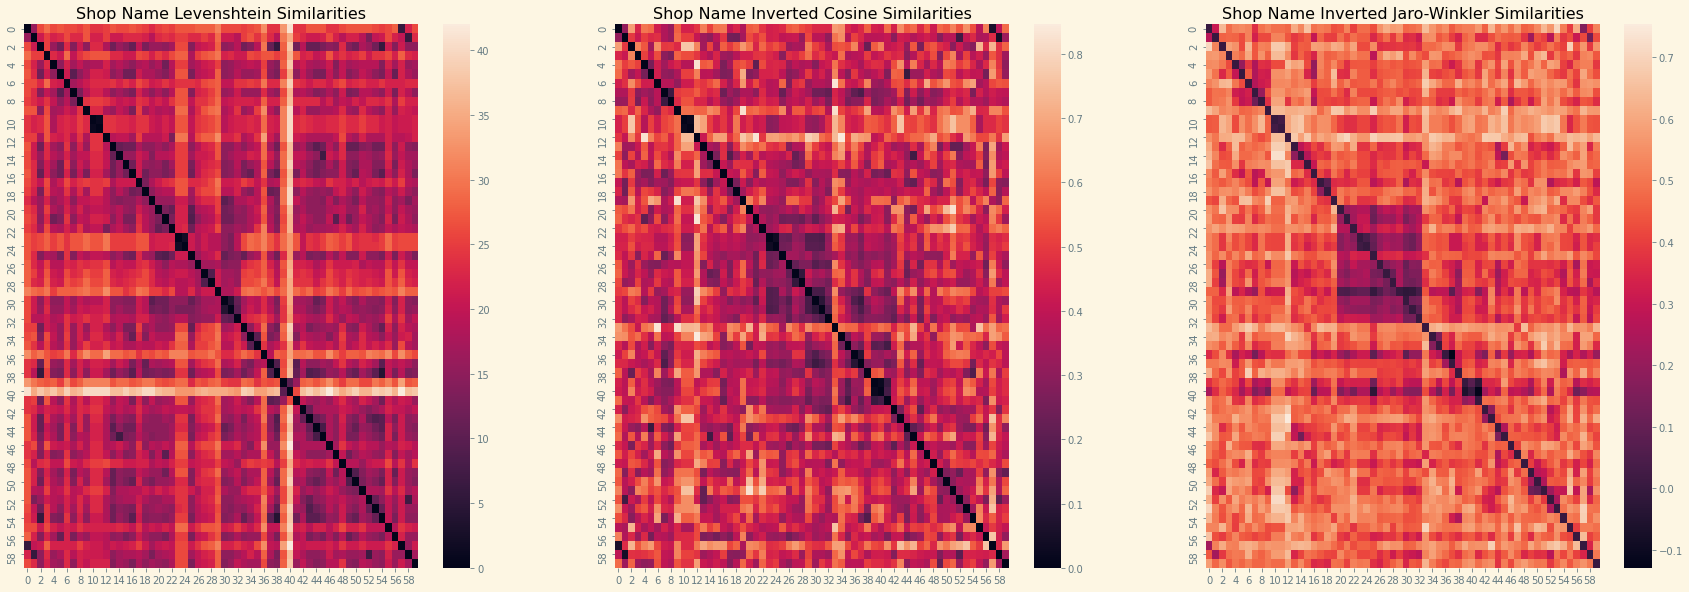

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.set_title('Shop Name Levenshtein Similarities')
ax2.set_title('Shop Name Inverted Cosine Similarities')
ax3.set_title('Shop Name Inverted Jaro-Winkler Similarities')
sns.heatmap(shop_levmat, ax=ax1)
sns.heatmap(shop_invcosmat, ax=ax2)
sns.heatmap(shop_invjwmat, ax=ax3)

In [44]:
test = shops.shop_name.apply(lambda x: x.split()[0])
test.unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

We can recognize some city names of Russia in the shop names! Let's scrape all of the Russia city names off of https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Russia

In [45]:
from scrape_cities import getCityNames

cities = getCityNames()
cities[:10]

['Абакан',
 'Абаза',
 'Абдулино',
 'Абинск',
 'Ачинск',
 'Адыгейск',
 'Агидель',
 'Агрыз',
 'Ак-Довурак',
 'Ахтубинск']

In [46]:
shop_names = shops.shop_name.unique()
shop_city = []

for name in shop_names:
    city_match = []
    for c in cities:
        if re.findall(c, name)!=[]:
            city_match.append(c)
    shop_city.append(city_match)
    
shop_name_df = pd.DataFrame(shop_city, index=shop_names, columns=['match1', 'match2', 'match3'])
shop_name_df = shops.merge(shop_name_df, right_on=shop_name_df.index, left_on='shop_name', how='right')
shop_name_df

,shop_name,shop_id,match1,match2,match3
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,None,None
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,None,None
2,"Адыгея ТЦ ""Мега""",2,None,None,None
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,None,None
4,"Волжский ТЦ ""Волга Молл""",4,Волжск,Волжский,None
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,None,None
6,"Воронеж (Плехановская, 13)",6,Воронеж,None,None
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,None,None
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,None,None
9,Выездная Торговля,9,None,None,None


Great, we've matched up 52 out of 60 shops to a city name.  
However, the other 8 shops have no matches and some shops have more than one city match (see the last entry above).

In [47]:
shop_name_df.loc[shop_name_df.match1.isna() | shop_name_df.match2.notna()]

,shop_name,shop_id,match1,match2,match3
2,"Адыгея ТЦ ""Мега""",2,None,None,None
4,"Волжский ТЦ ""Волга Молл""",4,Волжск,Волжский,None
9,Выездная Торговля,9,None,None,None
10,Жуковский ул. Чкалова 39м?,10,Жуков,Жуковский,None
11,Жуковский ул. Чкалова 39м²,11,Жуков,Жуковский,None
12,Интернет-магазин ЧС,12,None,None,None
19,"Курск ТЦ ""Пушкинский""",19,Курск,Пушкин,None
34,"Н.Новгород ТРЦ ""РИО""",34,None,None,None
35,"Н.Новгород ТРЦ ""Фантастика""",35,None,None,None
40,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40,Остров,Островной,Ростов


In [48]:
# multi matches
shop_name_df.loc[4, 'match1'] = 'Волжский' # cities[1013]
shop_name_df.loc[10:11, 'match1'] = 'Жуковский' # cities[1102]
shop_name_df.loc[40, 'match1'] = 'Ростов-на-Дону' # cities[742]
# no matches
shop_name_df.loc[2, 'match1'] = 'Адыгейск' # cities[5]
shop_name_df.loc[9, 'match1'] = 'Outbound Trading'
shop_name_df.loc[12, 'match1'] = 'Online store of emergency situations'
shop_name_df.loc[34:35, 'match1'] = 'Нижний Новгород' # cities[583]
shop_name_df.loc[42:43, 'match1'] = 'Санкт-Петербург' # cities[755]
shop_name_df.loc[55, 'match1'] = 'Digital warehouse 1C-Online'

Now that we've matched up all 60 shops to 32 cities in total, let's also add a label for the non-local shops such as online shops.

In [49]:
shop_name_df['is_local'] = 1
shop_name_df.loc[[9,12,55], 'is_local'] = 0
shop_name_df = shop_name_df.drop(['match2', 'match3'], axis=1)
shop_name_df['city_id'] = le.fit_transform(shop_name_df.match1)
shop_name_df.head()

,shop_name,shop_id,match1,is_local,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,1,30
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,1,30
2,"Адыгея ТЦ ""Мега""",2,Адыгейск,1,3
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1,4
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1,5


Finally, we'll add it to the training set

In [50]:
train = train.merge(shop_name_df[['shop_id', 'city_id', 'is_local']], on='shop_id', how='left')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,main_category_id,sub_main_category_id,sub_category_id,city_id,is_local
0,02.01.2013,0,59,22154,999.00,1.0,37,7,10,1,31,1
1,03.01.2013,0,25,2552,899.00,1.0,58,9,12,27,14,1
2,05.01.2013,0,25,2552,899.00,-1.0,58,9,12,27,14,1
3,06.01.2013,0,25,2554,1709.05,1.0,58,9,12,27,14,1
4,15.01.2013,0,25,2555,1099.00,1.0,56,9,12,3,14,1


# Shop & Category Features

In [62]:
def mode(x):
    return x.value_counts().index[0]
def mmode(x):
    return x.value_counts().index[-1]
def mode_freq(x):
    return (x.value_counts() / x.count()).iloc[0]
def mmode_freq(x):
    return (x.value_counts() / x.count()).iloc[-1]

In [63]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,main_category_id,sub_main_category_id,sub_category_id,city_id,is_local
0,02.01.2013,0,59,22154,999.00,1.0,37,7,10,1,31,1
1,03.01.2013,0,25,2552,899.00,1.0,58,9,12,27,14,1
2,05.01.2013,0,25,2552,899.00,-1.0,58,9,12,27,14,1
3,06.01.2013,0,25,2554,1709.05,1.0,58,9,12,27,14,1
4,15.01.2013,0,25,2555,1099.00,1.0,56,9,12,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2935836,10.10.2015,33,25,7409,299.00,1.0,55,9,12,2,14,1
2935837,09.10.2015,33,25,7460,299.00,1.0,55,9,12,2,14,1
2935838,14.10.2015,33,25,7459,349.00,1.0,55,9,12,2,14,1
2935839,22.10.2015,33,25,7440,299.00,1.0,57,9,12,8,14,1


In [68]:
mode_aggs = [mode, mode_freq, mmode, mmode_freq]
aggs = ['mean', 'std', 'median' , 'min', 'max', 'skew']

In [ ]:
shop_sales = train.groupby(['date_block_num', 'shop_id']).agg({
    'item_id': mode_aggs,
    'item_price': mode_aggs + aggs,
    'item_cnt_day': mode_aggs + aggs,
    'item_category_id': mode_aggs,
    'main_category_id': mode_aggs,
    'sub_main_category_id': mode_aggs,
    'sub_category_id': mode_aggs,
})

In [ ]:
item_sales = train.groupby(['date_block_num', 'item_id']).agg({
    'shop_id': mode_aggs,
    'item_price': mode_aggs + aggs,
    'item_cnt_day': mode_aggs + aggs,
    'item_category_id': mode_aggs,
    'main_category_id': mode_aggs,
    'sub_main_category_id': mode_aggs,
    'sub_category_id': mode_aggs,
    'city_id': mode_aggs,
    'is_local': mode_aggs
})

In [ ]:
main_category_sales = train.groupby(['date_block_num', 'main_category_id']).agg({
    'i'
})

In [69]:
shop_sales

item_id                             item_price  \
                          mode mode_freq  mmode mmode_freq       mode   
date_block_num shop_id                                                  
0              0         12134  0.004381   8602   0.000209       76.0   
               1          2931  0.005568  21933   0.000371       76.0   
               2          4164  0.008403     27   0.000934      149.0   
               3         11041  0.010681   4013   0.001335      399.0   
               4          7856  0.008976    992   0.000528      149.0   
...                        ...       ...    ...        ...        ...   
33             55        13097  0.021106   2334   0.000728     1999.0   
               56        20949  0.024034  15793   0.000858      299.0   
               57        20949  0.014320  16142   0.000477      399.0   
               58        20949  0.020331   1813   0.000753      399.0   
               59        20949  0.020576   5002   0.001372      299.0   

                                                                   \
                       mode_freq    mmode mmode_freq         mean   
date_block_num shop_id                                              
0              0        0.043605   171.00   0.000209   531.262049   
               1        0.055308   128.00   0.000371   511.780252   
               2        0.119514   370.00   0.000934   960.654952   
               3        0.113485   399.01   0.001335   734.329786   
               4        0.128828  1100.00   0.000528   702.325446   
...                          ...      ...        ...          ...   
33             55       0.060408   230.00   0.000728   751.103833   
               56       0.086695    28.00   0.000858  1089.635193   
               57       0.100716   859.00   0.000477  1061.750358   
               58       0.100151  2998.00   0.000753  1211.920188   
               59       0.087791   288.00   0.001372  1129.254066   

                                     ... main_category_id             \
                                std  ...            mmode mmode_freq   
date_block_num shop_id               ...                               
0              0        1148.438481  ...               14   0.002504   
               1        1156.247784  ...                6   0.003712   
               2        1754.629051  ...               12   0.000934   
               3        1098.743248  ...                6   0.004005   
               4        1262.341385  ...               14   0.001584   
...                             ...  ...              ...        ...   
33             55        944.287020  ...                6   0.094614   
               56       2137.631915  ...                4   0.006009   
               57       2171.161196  ...               12   0.002387   
               58       2664.985755  ...               12   0.002259   
               59       1889.385793  ...                4   0.002743   

                       sub_main_category_id                             \
                                       mode mode_freq mmode mmode_freq   
date_block_num shop_id                                                   
0              0                         10  0.414354    17   0.002504   
               1                         10  0.412027     9   0.003712   
               2                         10  0.229692    15   0.000934   
               3                          8  0.316422     9   0.004005   
               4                          8  0.324182    17   0.001584   
...                                     ...       ...   ...        ...   
33             55                         8  0.540757     7   0.000728   
               56                        10  0.266953     4   0.006009   
               57                        10  0.325060    15   0.002387   
               58                        10  0.306476    15   0.002259   
               59                        10  0.222222     4   